In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checksv

YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


In [ ]:

# %cd /content
# !curl -L "https://public.roboflow.com/ds/54IBXkxkC5?key=RvWJf3xji3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
%cd /content
!curl -L "https://app.roboflow.com/ds/SX2Vh32yZM?key=3sbJseimzD" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip;

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/000000000776_jpg.rf.57f1eb910f6a890ebe5b602a380211c7.txt  
 extracting: train/labels/000000000785_jpg.rf.c666e03f24f88e024a1040d594d7cd09.txt  
 extracting: train/labels/000000000802_jpg.rf.fcd5fd25a1542d76b48c904f7c7676bf.txt  
 extracting: train/labels/000000000885_jpg.rf.fa0ed0beb25a4fa9d442da261a5eafb3.txt  
 extracting: train/labels/000000001000_jpg.rf.553032c69943fb60280f7e956179681c.txt  
 extracting: train/labels/000000001268_jpg.rf.ccb307df52c3764ffd46fe7956c8a176.txt  
 extracting: train/labels/000000001296_jpg.rf.612dda336eb2bbfa9657f79d10b22b0a.txt  
 extracting: train/labels/000000001353_jpg.rf.74fc274c2ab59fb20b33388f445bb49d.txt  
 extracting: train/labels/000000001425_jpg.rf.76e1d6a38b3855bec0940a926074585b.txt  
 extracting: train/labels/000000001490_jpg.rf.76a4f795cad19d099f2de7fdce43f07a.txt  
 extracting: train/labels/000000001503_jpg.rf.7ac62a7399f0b698f4c9c8f5c9dc67d4.txt  
 extracting: t

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/data.yaml

train: ../train/images
val: ../valid/images

nc: 80
names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '9']

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [256, 3]],  # 0-P1/2
   [-1, 1, Conv, [512, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [512]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# Train YOLOv5s on COCO128 for 10 epochs
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 10 --epochs 20 --data /content/data.yaml --cfg /content/yolov5/models/custom_yolov5s.yaml  --weights '' --cache

/content/yolov5
train: weights=, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=10, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
display.Image(filename='/content/yolov5/runs/train/exp3/train_batch0.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
display.Image(filename='/content/yolov5/runs/train/exp3/train_batch1.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
display.Image(filename='/content/yolov5/runs/train/exp3/train_batch2.jpg', width=900)

In [ ]:
%cd /content/yolov5/
!python val.py --weights /content/yolov5/runs/train/exp5/weights/best.pt --data /content/data.yaml  --img 416 --iou 0.65

In [ ]:
# Tensorboard  (optional)
%load_ext tensorboard
%tensorboard --logdir runs/train

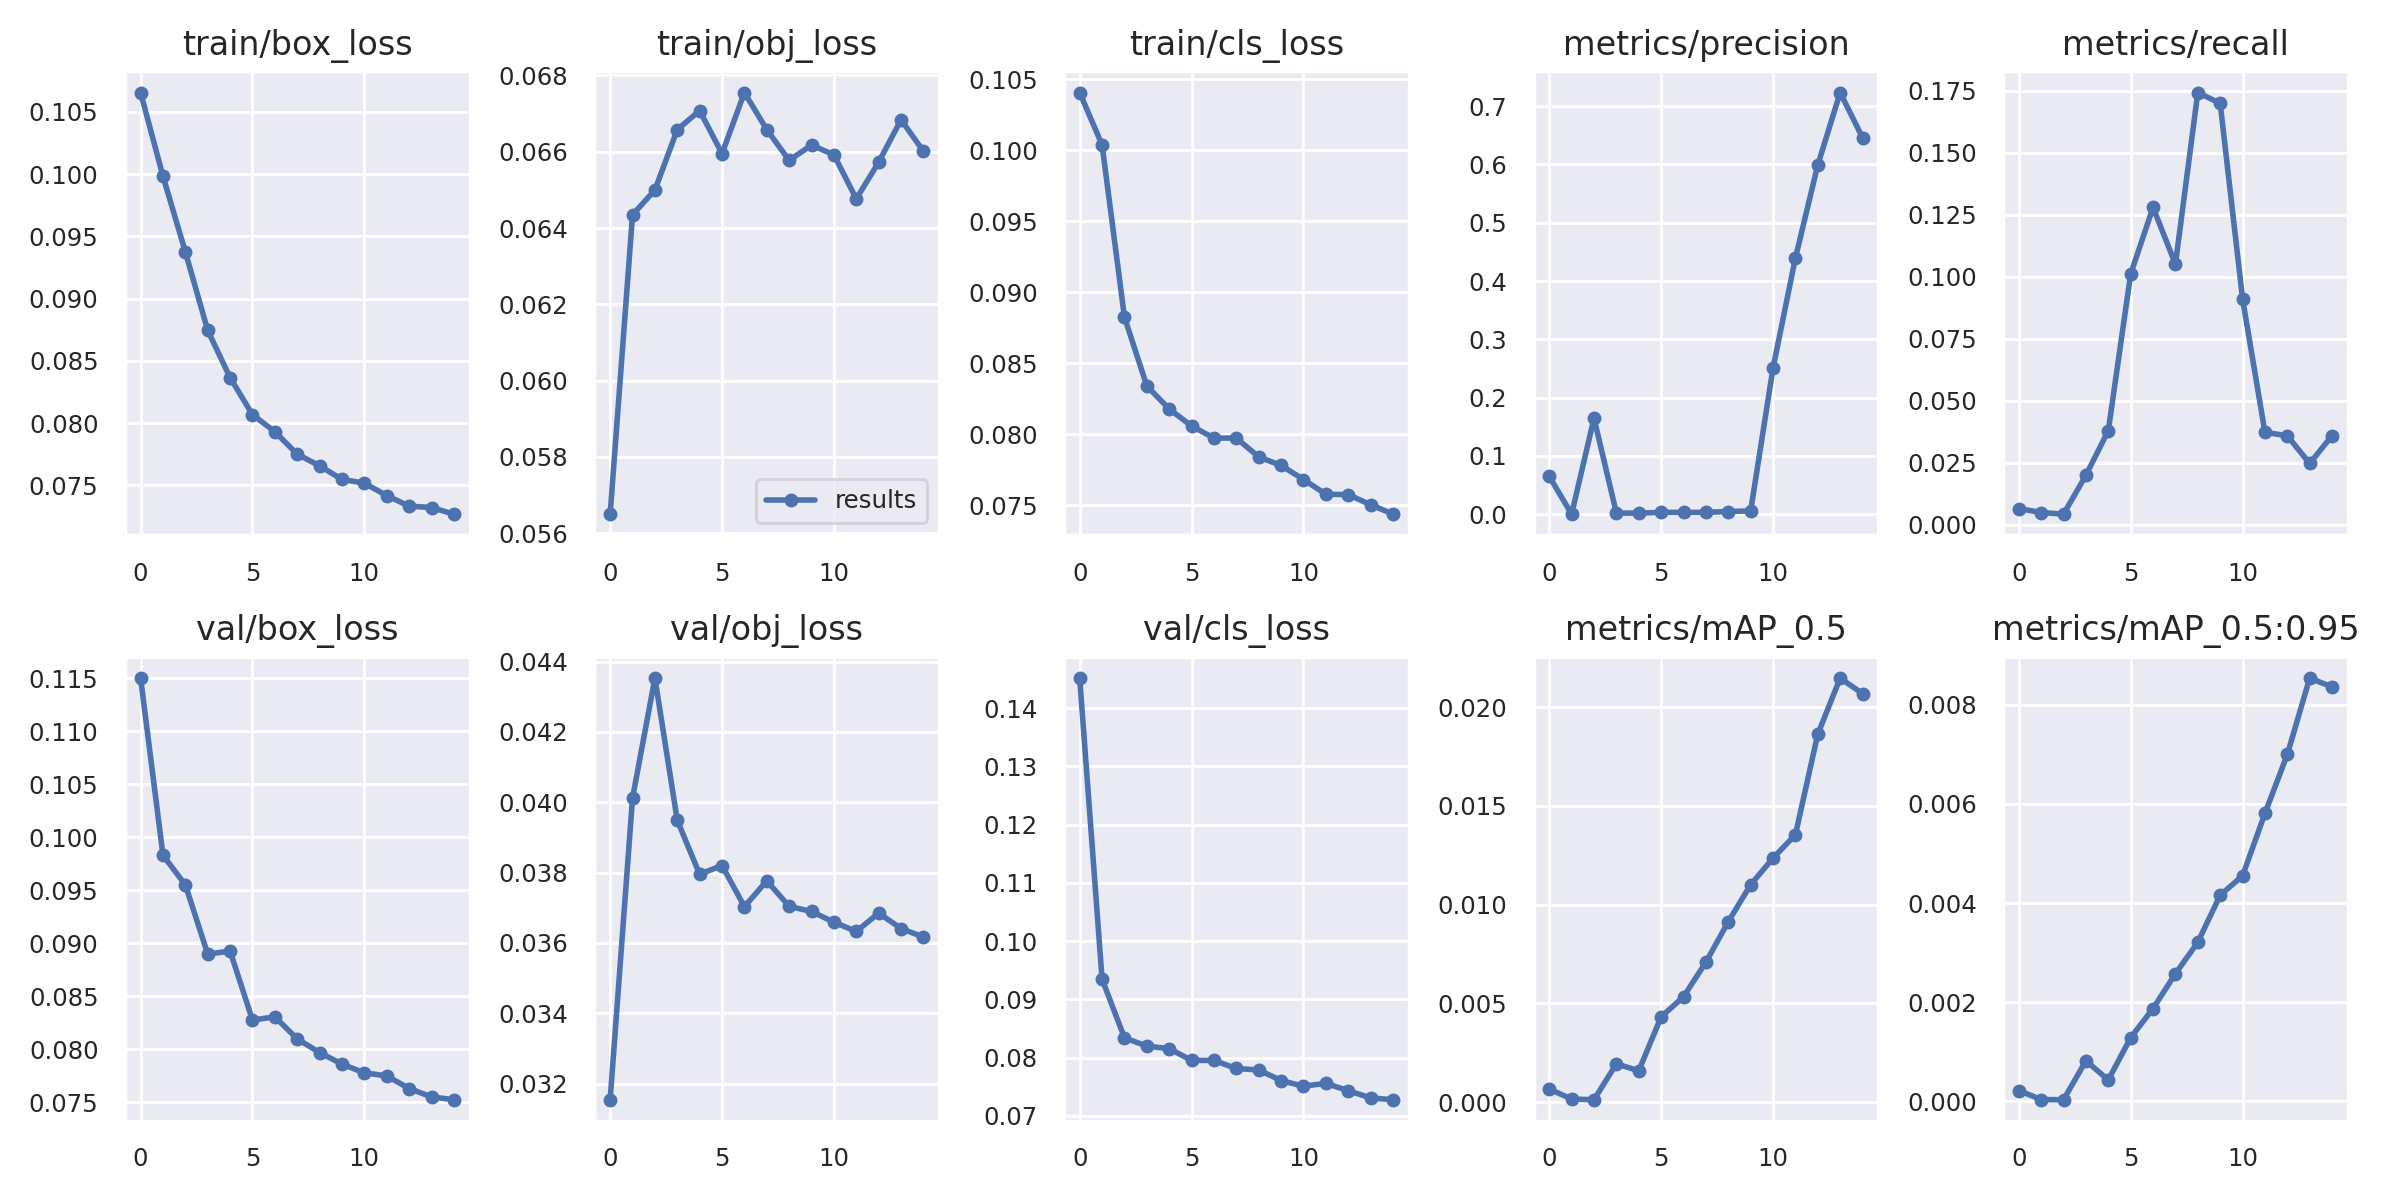

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
display.Image(filename='/content/yolov5/runs/train/exp3/results.png', width=1000)  # view results.png

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp3/weights/best.pt --img 416 --conf 0.25 --source data/images

detect: weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], source=data/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-233-g7433d38 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7448285 parameters, 0 gradients, 16.9 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 416x320 1 person, Done. (0.016s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 256x416 1 person, Done. (0.017s)
Speed: 0.3ms pre-process, 16.2ms inference, 1.1ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp2


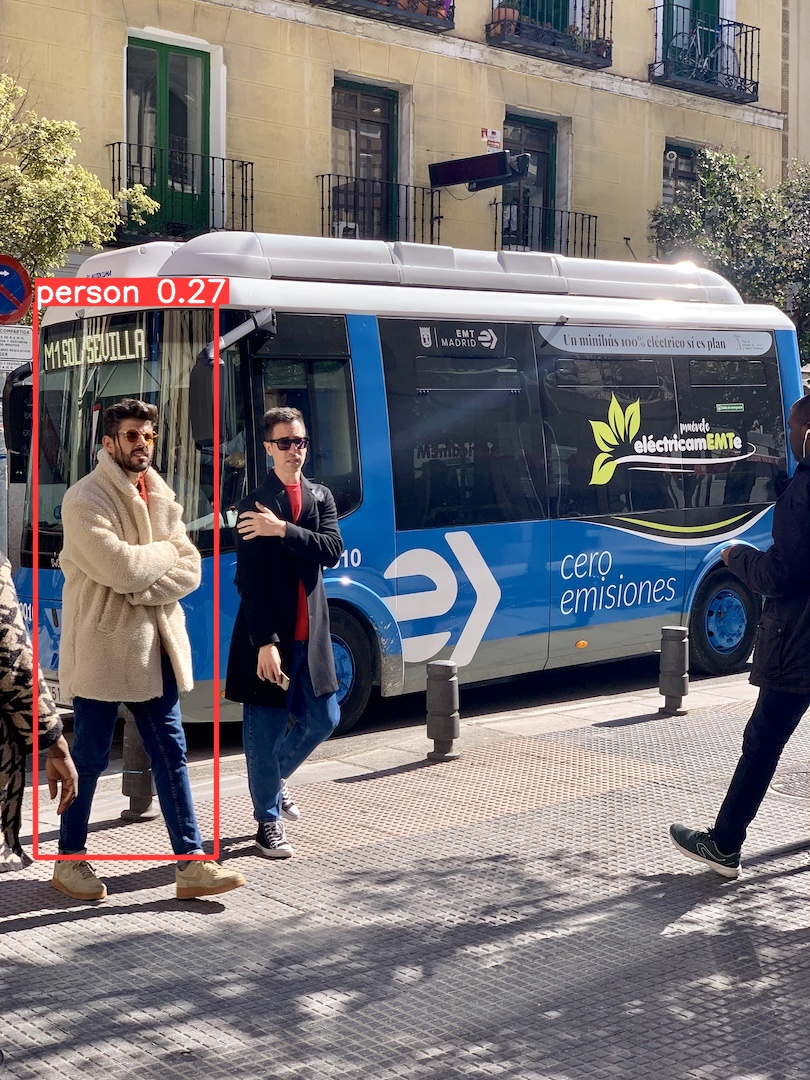

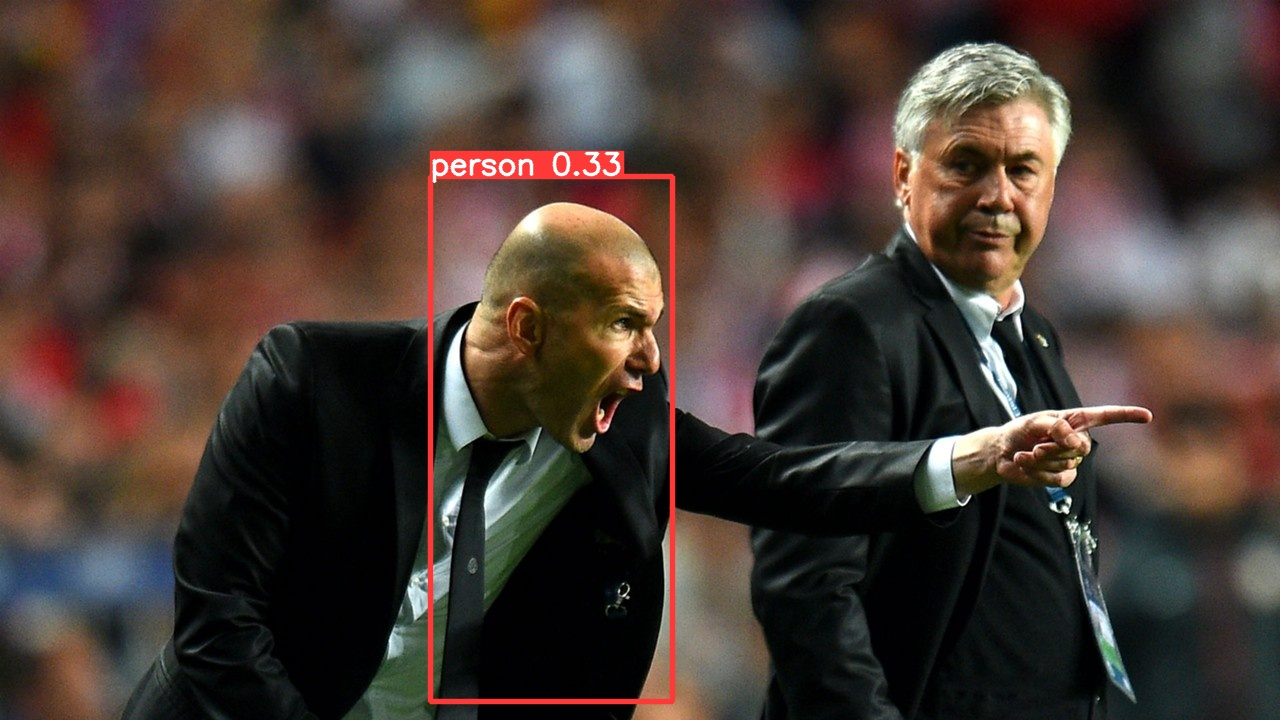

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")